## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List
import warnings

warnings.filterwarnings('ignore')

# Set style for thesis-quality figures
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

# Set color palette
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration

In [2]:
# Paths
DATA_DIR = Path(r"d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data")
OUTPUT_DIR = DATA_DIR / 'rq1_analysis'
FIGURES_DIR = OUTPUT_DIR / 'figures'

# Create output directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Input file
EVALUATION_BASE = DATA_DIR / 'evaluation_base.csv'

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Figures directory: {FIGURES_DIR}")
print(f"Input file: {EVALUATION_BASE}")

Data directory: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data
Output directory: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis
Figures directory: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures
Input file: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\evaluation_base.csv


## Load Data

### Important: Understanding Vulnerability Counts

The dataset contains two types of vulnerability counts:

**1. Total Counts** (includes duplicates):
- `total_vulnerabilities_identified`: All vulnerability occurrences (same CWE detected by multiple tools = counted multiple times)
- `total_vulnerabilities_fixed`: All fixed occurrences
- `total_vulnerabilities_remaining`: All remaining occurrences

**2. Unique CWE Counts** (no duplicates):
- `unique_cwes_identified`: Distinct CWE types found (same CWE detected by multiple tools = counted once)
- `unique_cwes_fixed`: Distinct CWE types fixed
- `unique_cwes_remaining`: Distinct CWE types remaining

**Which to use?**
- **For tool comparison & overlap analysis**: Use total counts to see all detections
- **For fix effectiveness & fix provider analysis**: Use unique counts (aligns with `fix_provider_llm` and `fix_provider_rule_based`)
- **For reporting distinct vulnerability types**: Use unique counts

**Note**: `fix_provider_llm` + `fix_provider_rule_based` + `fix_provider_unknown` = `unique_cwes_fixed` (NOT `total_vulnerabilities_fixed`)

In [3]:
# Load evaluation base dataset
df = pd.read_csv(EVALUATION_BASE)

print(f"Dataset loaded: {len(df)} workflows")
print(f"\nColumns: {len(df.columns)}")
print(f"\nPrompt types:")
print(df['prompt_type'].value_counts())

# Display basic info
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset loaded: 84 workflows

Columns: 36

Prompt types:
prompt_type
SecurityEval    42
Manual          42
Name: count, dtype: int64

Dataset shape: (84, 36)

First few rows:


,workflow_id,workflow,timestamp,file,source_file,prompt_type,prompt,llm_response,vulnerabilities_found,total_vulnerabilities_identified,...,remaining_cwes,fix_provider_llm,fix_provider_rule_based,fix_provider_unknown,fix_provider_llm_cwes,fix_provider_rule_cwes,fix_provider_unknown_cwes,unique_cwes_fixed,unique_cwes_remaining,unique_cwes_identified
0,20251219_151500,dataset_prompt_analysis,2025-12-19 14:15:29.482228+00:00,CWE-020/author_1.py,CWE-020/author_1.py,SecurityEval,import yaml\n\n\ndef yaml_load(filename):\n ...,def yaml_load(filename):\n with open(filena...,2,2,...,[],0,2,0,[],[],[],2,0,2
1,20251219_152650,dataset_prompt_analysis,2025-12-19 14:27:08.255669+00:00,CWE-020/author_2.py,CWE-020/author_2.py,SecurityEval,import xml.etree.ElementTree as ET\n\n\ndef pa...,def parse_xml(xml_string):\n return ET.from...,0,0,...,[],0,0,0,[],[],[],0,0,0
2,20251219_154533,dataset_prompt_analysis,2025-12-19 14:46:30.850674+00:00,CWE-022/author_1.py,CWE-022/author_1.py,SecurityEval,"import os\nfrom flask import Flask, request\n\...","@app.route('/deleteImage', methods=['POST'])\n...",3,3,...,[],3,0,0,[],[],[],1,0,1
3,20251219_155128,dataset_prompt_analysis,2025-12-19 14:51:43.477065+00:00,CWE-022/author_2.py,CWE-022/author_2.py,SecurityEval,import json\nimport urllib.request as request\...,def readJSON(url):\n with request.urlopen(u...,0,0,...,[],0,0,0,[],[],[],0,0,0
4,20251219_155343,dataset_prompt_analysis,2025-12-19 14:53:57.481675+00:00,CWE-078/author_1.py,CWE-078/author_1.py,SecurityEval,import subprocess\n\ndef executeCommand():\n ...,import shlex\nimport shutil\n\ndef executeComm...,0,0,...,[],0,0,0,[],[],[],0,0,0


## 1. Descriptive Statistics by Prompt Type

In [4]:
def compute_descriptive_stats(df: pd.DataFrame, prompt_type: str) -> Dict:
    """
    Compute descriptive statistics for a specific prompt type.
    
    Args:
        df: DataFrame with workflow data
        prompt_type: 'Manual' or 'SecurityEval'
        
    Returns:
        Dictionary with descriptive statistics
    """
    df_subset = df[df['prompt_type'] == prompt_type]
    
    total_workflows = len(df_subset)
    workflows_with_vulns = len(df_subset[df_subset['vulnerabilities_found'] > 0])
    workflows_without_vulns = total_workflows - workflows_with_vulns
    percentage_vulnerable = (workflows_with_vulns / total_workflows * 100) if total_workflows > 0 else 0
    
    stats = {
        'prompt_type': prompt_type,
        'total_workflows': total_workflows,
        'workflows_with_vulnerabilities': workflows_with_vulns,
        'workflows_without_vulnerabilities': workflows_without_vulns,
        'percentage_vulnerable': percentage_vulnerable,
        'mean_vulnerabilities': df_subset['vulnerabilities_found'].mean(),
        'median_vulnerabilities': df_subset['vulnerabilities_found'].median(),
        'std_vulnerabilities': df_subset['vulnerabilities_found'].std(),
        'min_vulnerabilities': df_subset['vulnerabilities_found'].min(),
        'max_vulnerabilities': df_subset['vulnerabilities_found'].max(),
        'q1_vulnerabilities': df_subset['vulnerabilities_found'].quantile(0.25),
        'q3_vulnerabilities': df_subset['vulnerabilities_found'].quantile(0.75),
    }
    
    return stats

# Compute statistics for each prompt type
stats_manual = compute_descriptive_stats(df, 'Manual')
stats_securityeval = compute_descriptive_stats(df, 'SecurityEval')

# Create summary DataFrame
stats_df = pd.DataFrame([stats_manual, stats_securityeval])

print("=" * 80)
print("DESCRIPTIVE STATISTICS BY PROMPT TYPE")
print("=" * 80)
print(stats_df.to_string(index=False))

# Save to CSV
stats_path = OUTPUT_DIR / 'rq1_descriptive_stats.csv'
stats_df.to_csv(stats_path, index=False)
print(f"\n✓ Descriptive statistics saved to: {stats_path}")

DESCRIPTIVE STATISTICS BY PROMPT TYPE
 prompt_type  total_workflows  workflows_with_vulnerabilities  workflows_without_vulnerabilities  percentage_vulnerable  mean_vulnerabilities  median_vulnerabilities  std_vulnerabilities  min_vulnerabilities  max_vulnerabilities  q1_vulnerabilities  q3_vulnerabilities
      Manual               42                              13                                 29              30.952381              2.857143                     0.0             5.870852                    0                   28                 0.0                2.75
SecurityEval               42                              21                                 21              50.000000              2.261905                     0.5             3.291227                    0                   14                 0.0                2.75

✓ Descriptive statistics saved to: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\rq1_descriptive_stats.csv


### Distribution of Vulnerabilities Found

In [5]:
# Distribution analysis
print("\n" + "=" * 80)
print("DISTRIBUTION OF VULNERABILITIES FOUND")
print("=" * 80)

for prompt_type in ['Manual', 'SecurityEval']:
    df_subset = df[df['prompt_type'] == prompt_type]
    print(f"\n{prompt_type}:")
    print(df_subset['vulnerabilities_found'].value_counts().sort_index())
    print(f"\nPercentage distribution:")
    print((df_subset['vulnerabilities_found'].value_counts(normalize=True).sort_index() * 100).round(2))


DISTRIBUTION OF VULNERABILITIES FOUND

Manual:
vulnerabilities_found
0     29
2      2
3      2
4      1
7      1
8      1
10     2
14     2
15     1
28     1
Name: count, dtype: int64

Percentage distribution:
vulnerabilities_found
0     69.05
2      4.76
3      4.76
4      2.38
7      2.38
8      2.38
10     4.76
14     4.76
15     2.38
28     2.38
Name: proportion, dtype: float64

SecurityEval:
vulnerabilities_found
0     21
1      2
2      8
3      1
4      1
5      1
6      2
7      2
8      2
9      1
14     1
Name: count, dtype: int64

Percentage distribution:
vulnerabilities_found
0     50.00
1      4.76
2     19.05
3      2.38
4      2.38
5      2.38
6      4.76
7      4.76
8      4.76
9      2.38
14     2.38
Name: proportion, dtype: float64


## 2. Thesis-Quality Visualizations

### Figure 1: Vulnerable vs Non-Vulnerable Workflows

✓ Figure saved: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig1_vulnerable_comparison.png


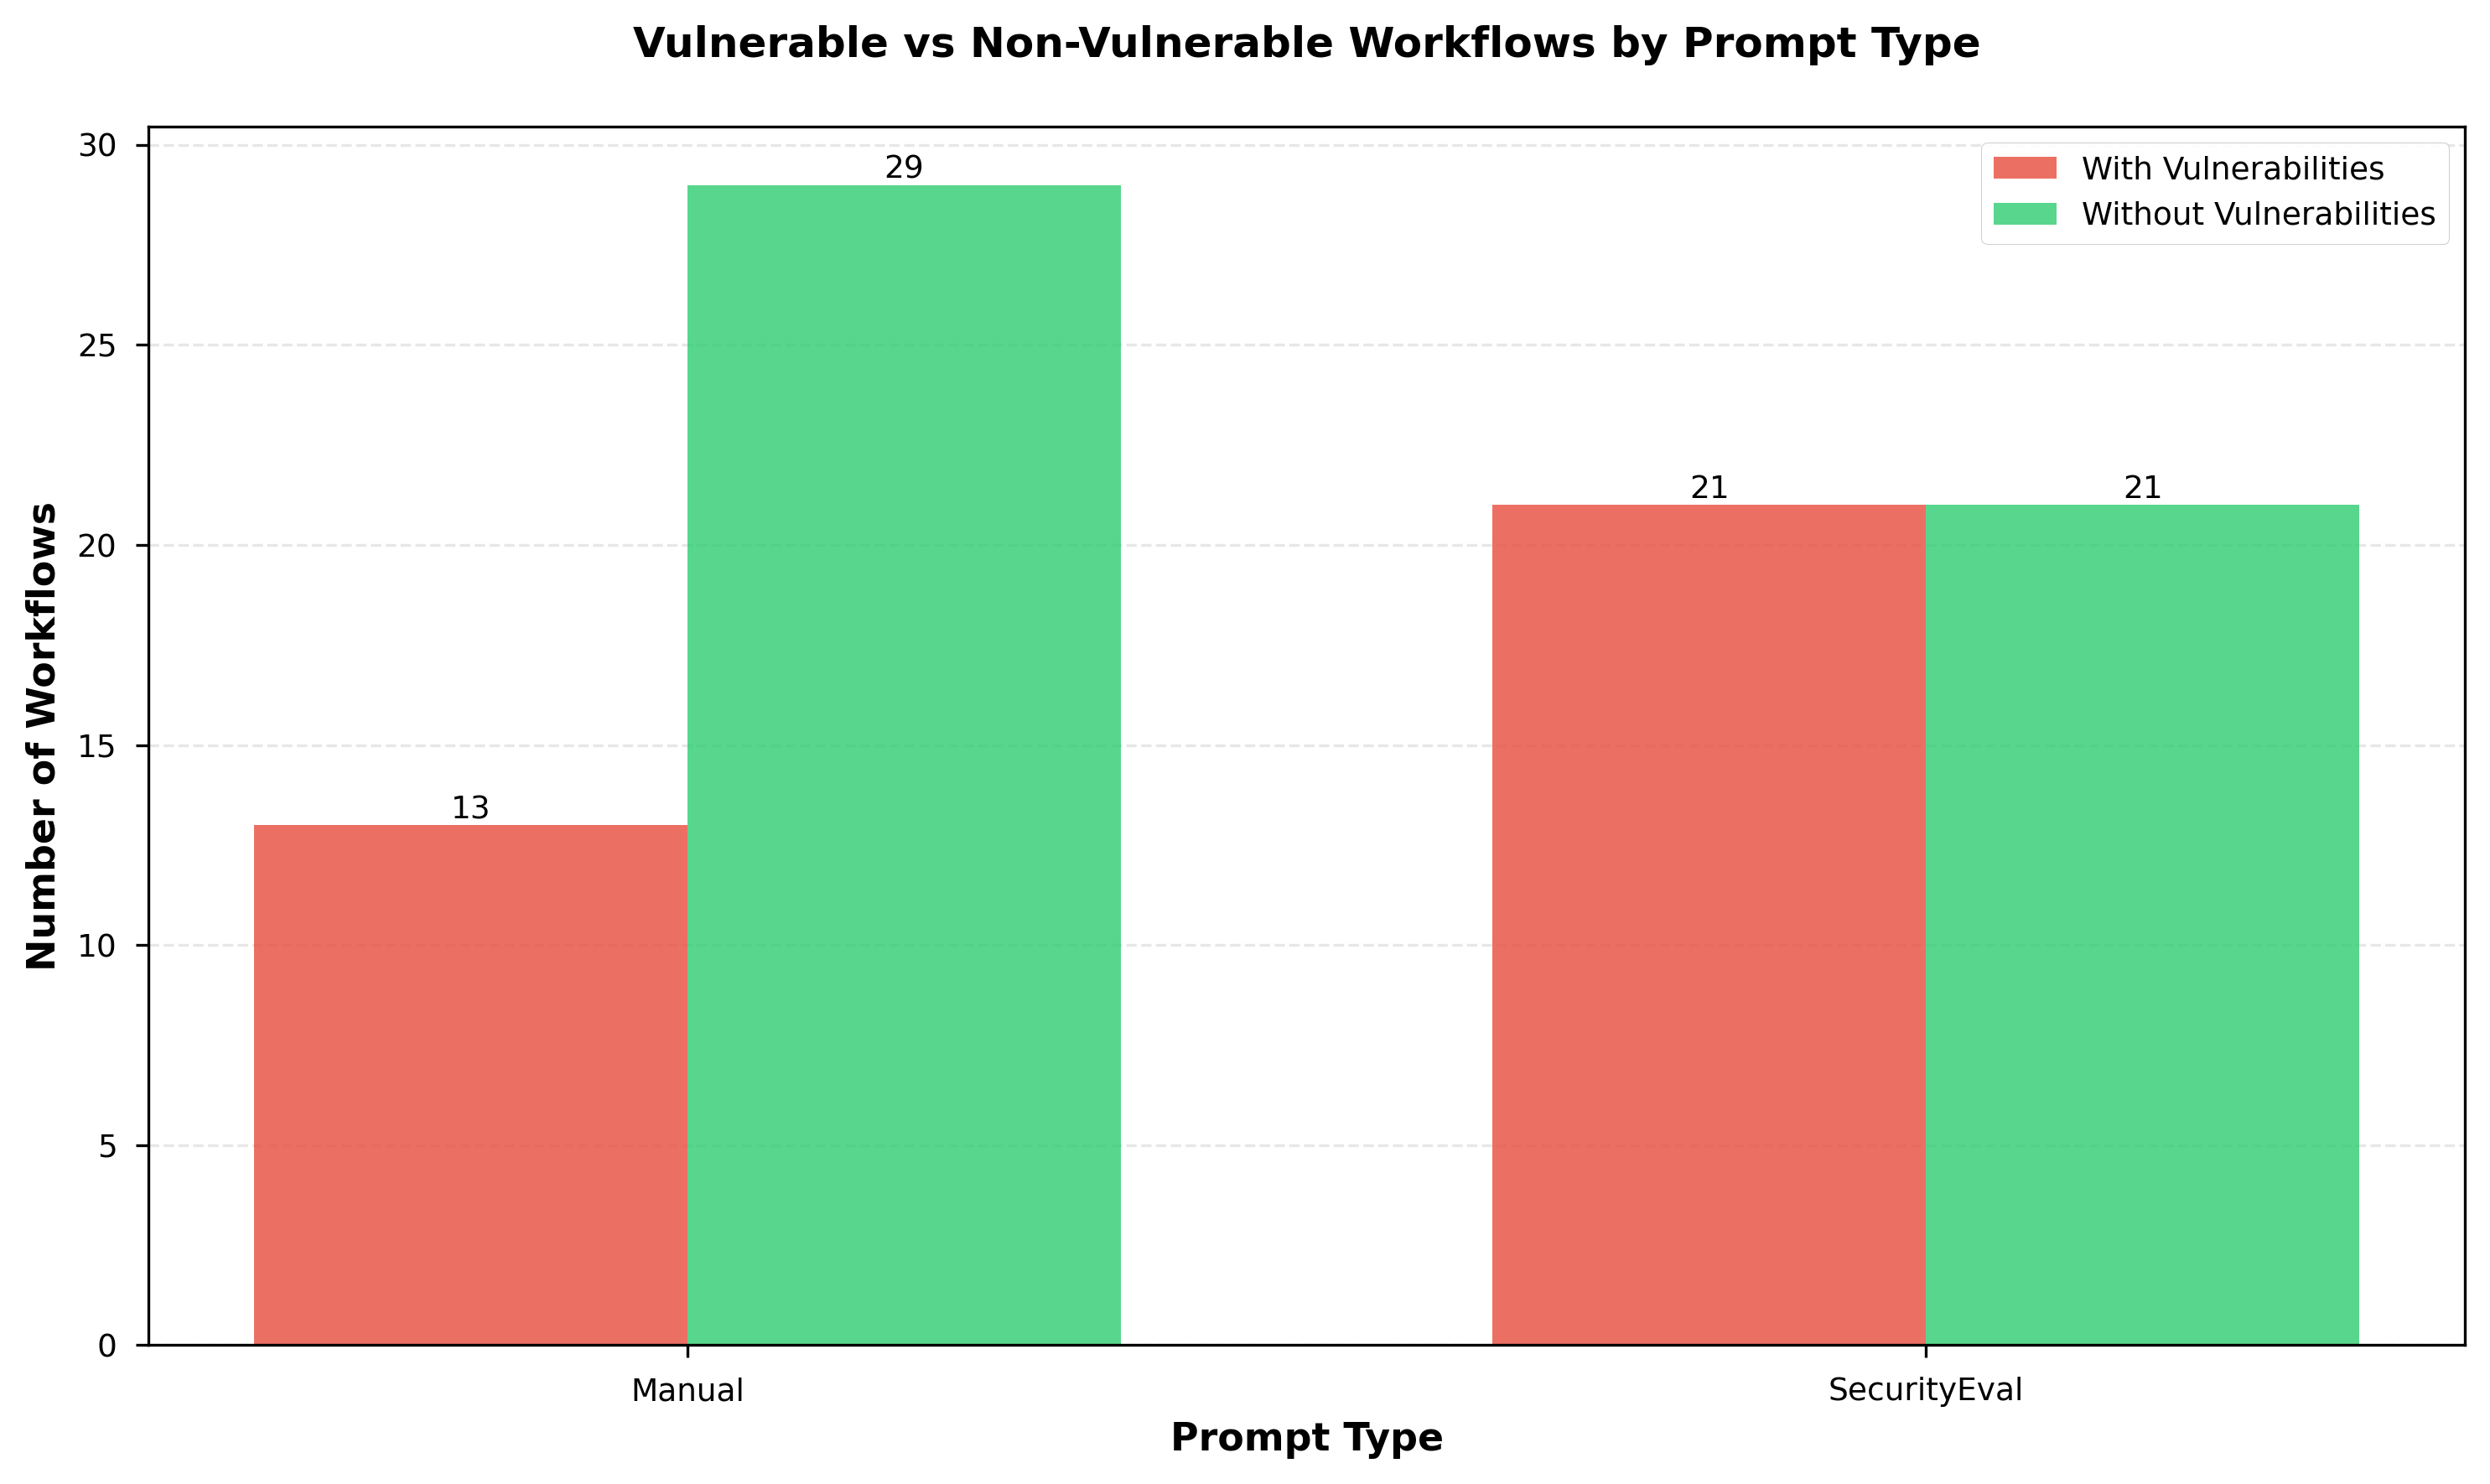

In [6]:
# Prepare data for vulnerable vs non-vulnerable comparison
comparison_data = []
for prompt_type in ['Manual', 'SecurityEval']:
    df_subset = df[df['prompt_type'] == prompt_type]
    with_vulns = len(df_subset[df_subset['vulnerabilities_found'] > 0])
    without_vulns = len(df_subset[df_subset['vulnerabilities_found'] == 0])
    comparison_data.append({
        'Prompt Type': prompt_type,
        'With Vulnerabilities': with_vulns,
        'Without Vulnerabilities': without_vulns
    })

comparison_df = pd.DataFrame(comparison_data)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df['Prompt Type']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['With Vulnerabilities'], width, 
               label='With Vulnerabilities', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Without Vulnerabilities'], width,
               label='Without Vulnerabilities', color='#2ecc71', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Prompt Type', fontweight='bold')
ax.set_ylabel('Number of Workflows', fontweight='bold')
ax.set_title('Vulnerable vs Non-Vulnerable Workflows by Prompt Type', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Prompt Type'])
ax.legend(loc='upper right', framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / 'fig1_vulnerable_comparison.png'
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
print(f"✓ Figure saved: {fig_path}")

plt.show()

### Figure 2: Histogram of Vulnerabilities Found

✓ Figure saved: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig2_vulnerabilities_histogram.png


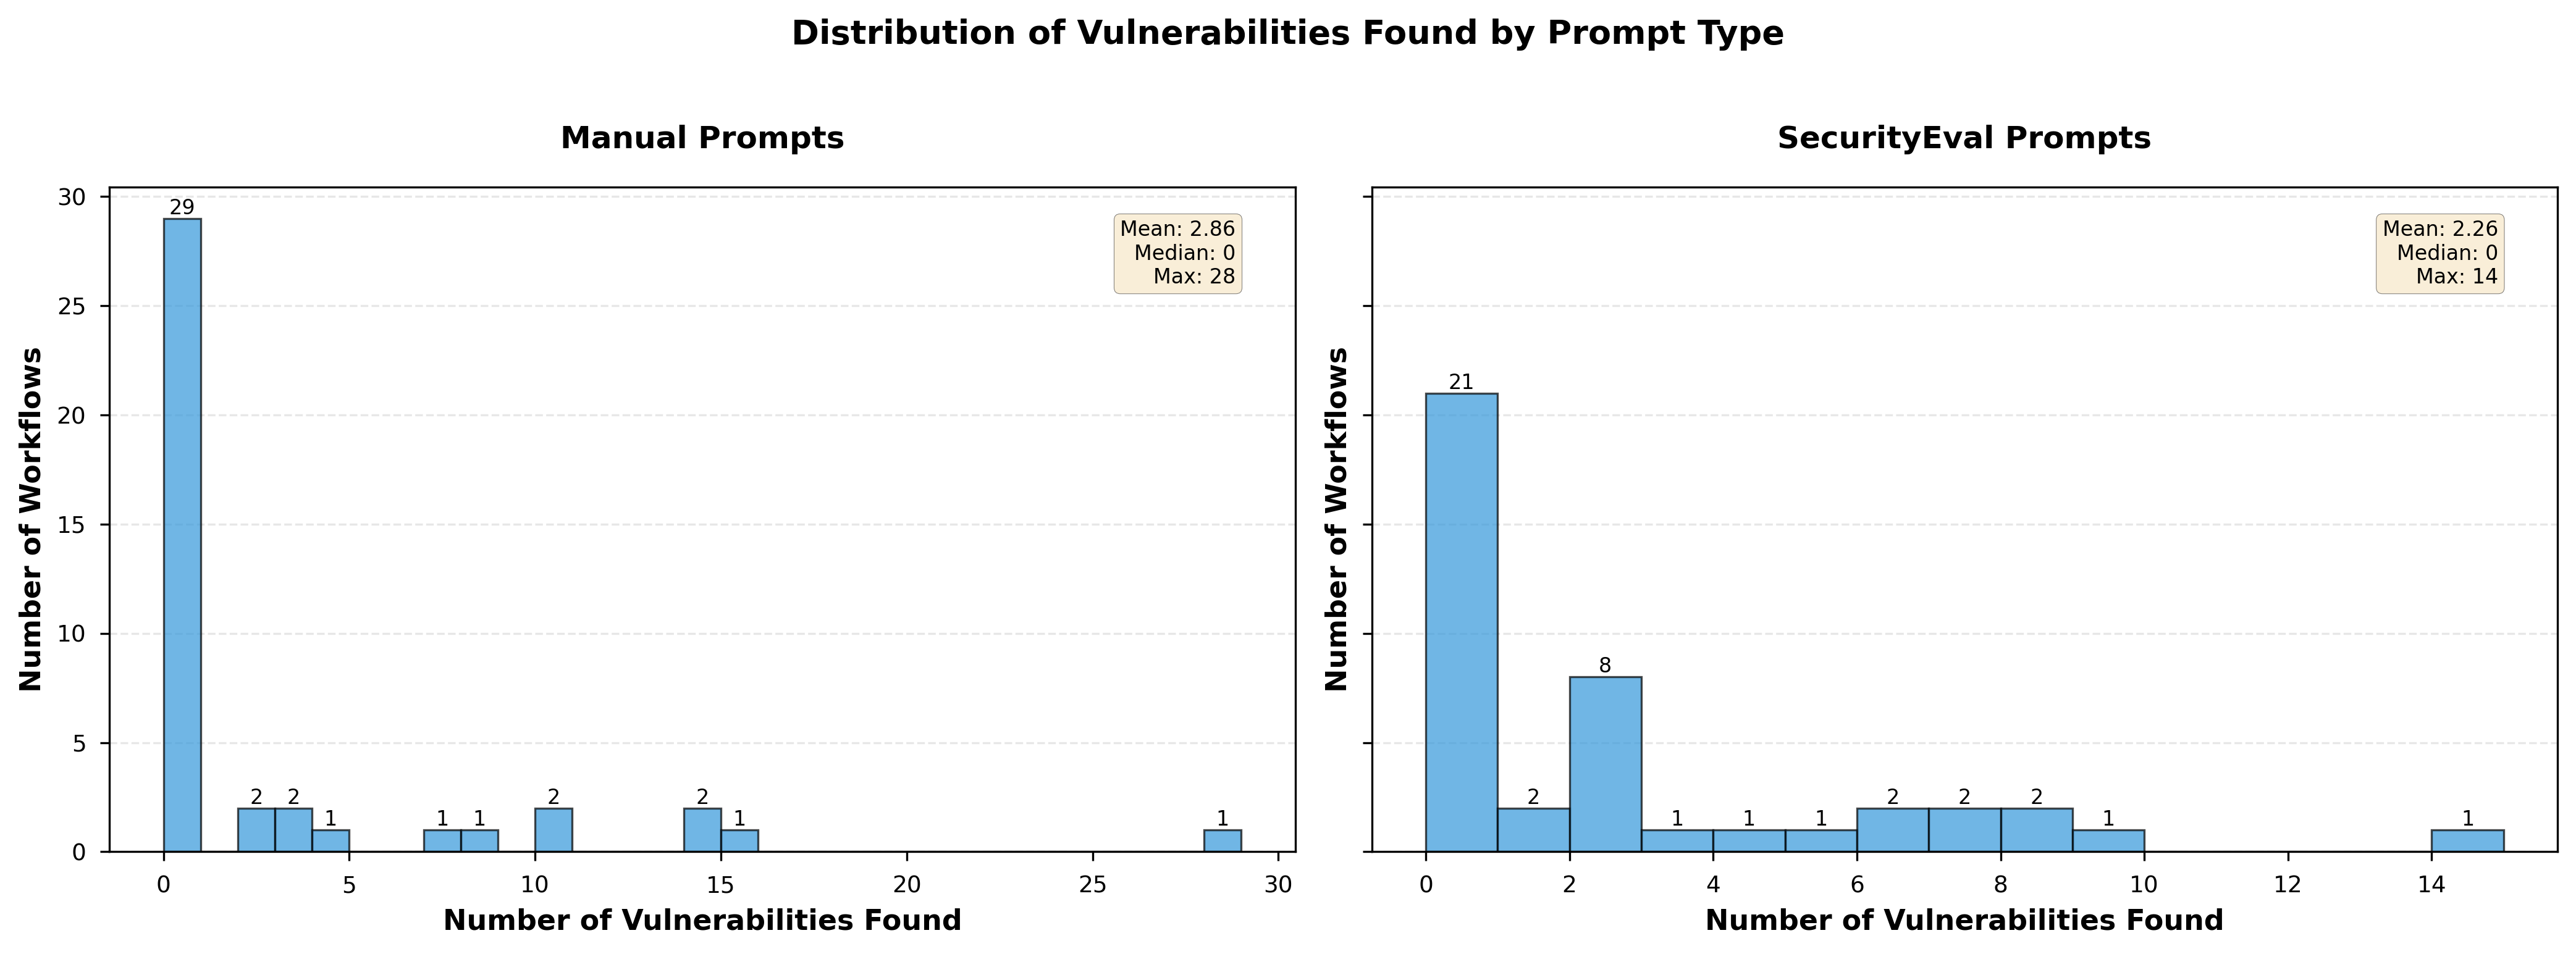

In [7]:
# Create side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for idx, prompt_type in enumerate(['Manual', 'SecurityEval']):
    df_subset = df[df['prompt_type'] == prompt_type]
    
    ax = axes[idx]
    
    if len(df_subset) > 0:
        # Get max value safely
        max_val = int(df_subset['vulnerabilities_found'].max())
        if pd.isna(max_val) or max_val < 0:
            max_val = 0
        
        # Create histogram
        counts, bins, patches = ax.hist(df_subset['vulnerabilities_found'], 
                                         bins=range(0, max_val + 2),
                                         color='#3498db', alpha=0.7, edgecolor='black', linewidth=0.8)
        
        # Add value labels on bars
        for count, patch in zip(counts, patches):
            if count > 0:
                height = patch.get_height()
                ax.text(patch.get_x() + patch.get_width()/2., height,
                        f'{int(count)}',
                        ha='center', va='bottom', fontsize=8)
        
        ax.set_xlabel('Number of Vulnerabilities Found', fontweight='bold')
        ax.set_ylabel('Number of Workflows', fontweight='bold')
        ax.set_title(f'{prompt_type} Prompts', fontweight='bold', pad=15)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        # Add statistics text box
        stats_text = f"Mean: {df_subset['vulnerabilities_found'].mean():.2f}\n"
        stats_text += f"Median: {df_subset['vulnerabilities_found'].median():.0f}\n"
        stats_text += f"Max: {max_val}"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=8)
    else:
        ax.text(0.5, 0.5, f'No data available for {prompt_type}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_xlabel('Number of Vulnerabilities Found', fontweight='bold')
        ax.set_ylabel('Number of Workflows', fontweight='bold')
        ax.set_title(f'{prompt_type} Prompts', fontweight='bold', pad=15)

fig.suptitle('Distribution of Vulnerabilities Found by Prompt Type', 
             fontweight='bold', fontsize=13, y=1.02)
plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / 'fig2_vulnerabilities_histogram.png'
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
print(f"✓ Figure saved: {fig_path}")

plt.show()

### Figure 3: Top 10 CWE Frequency Analysis

✓ Figure saved: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig3_top10_cwes.png


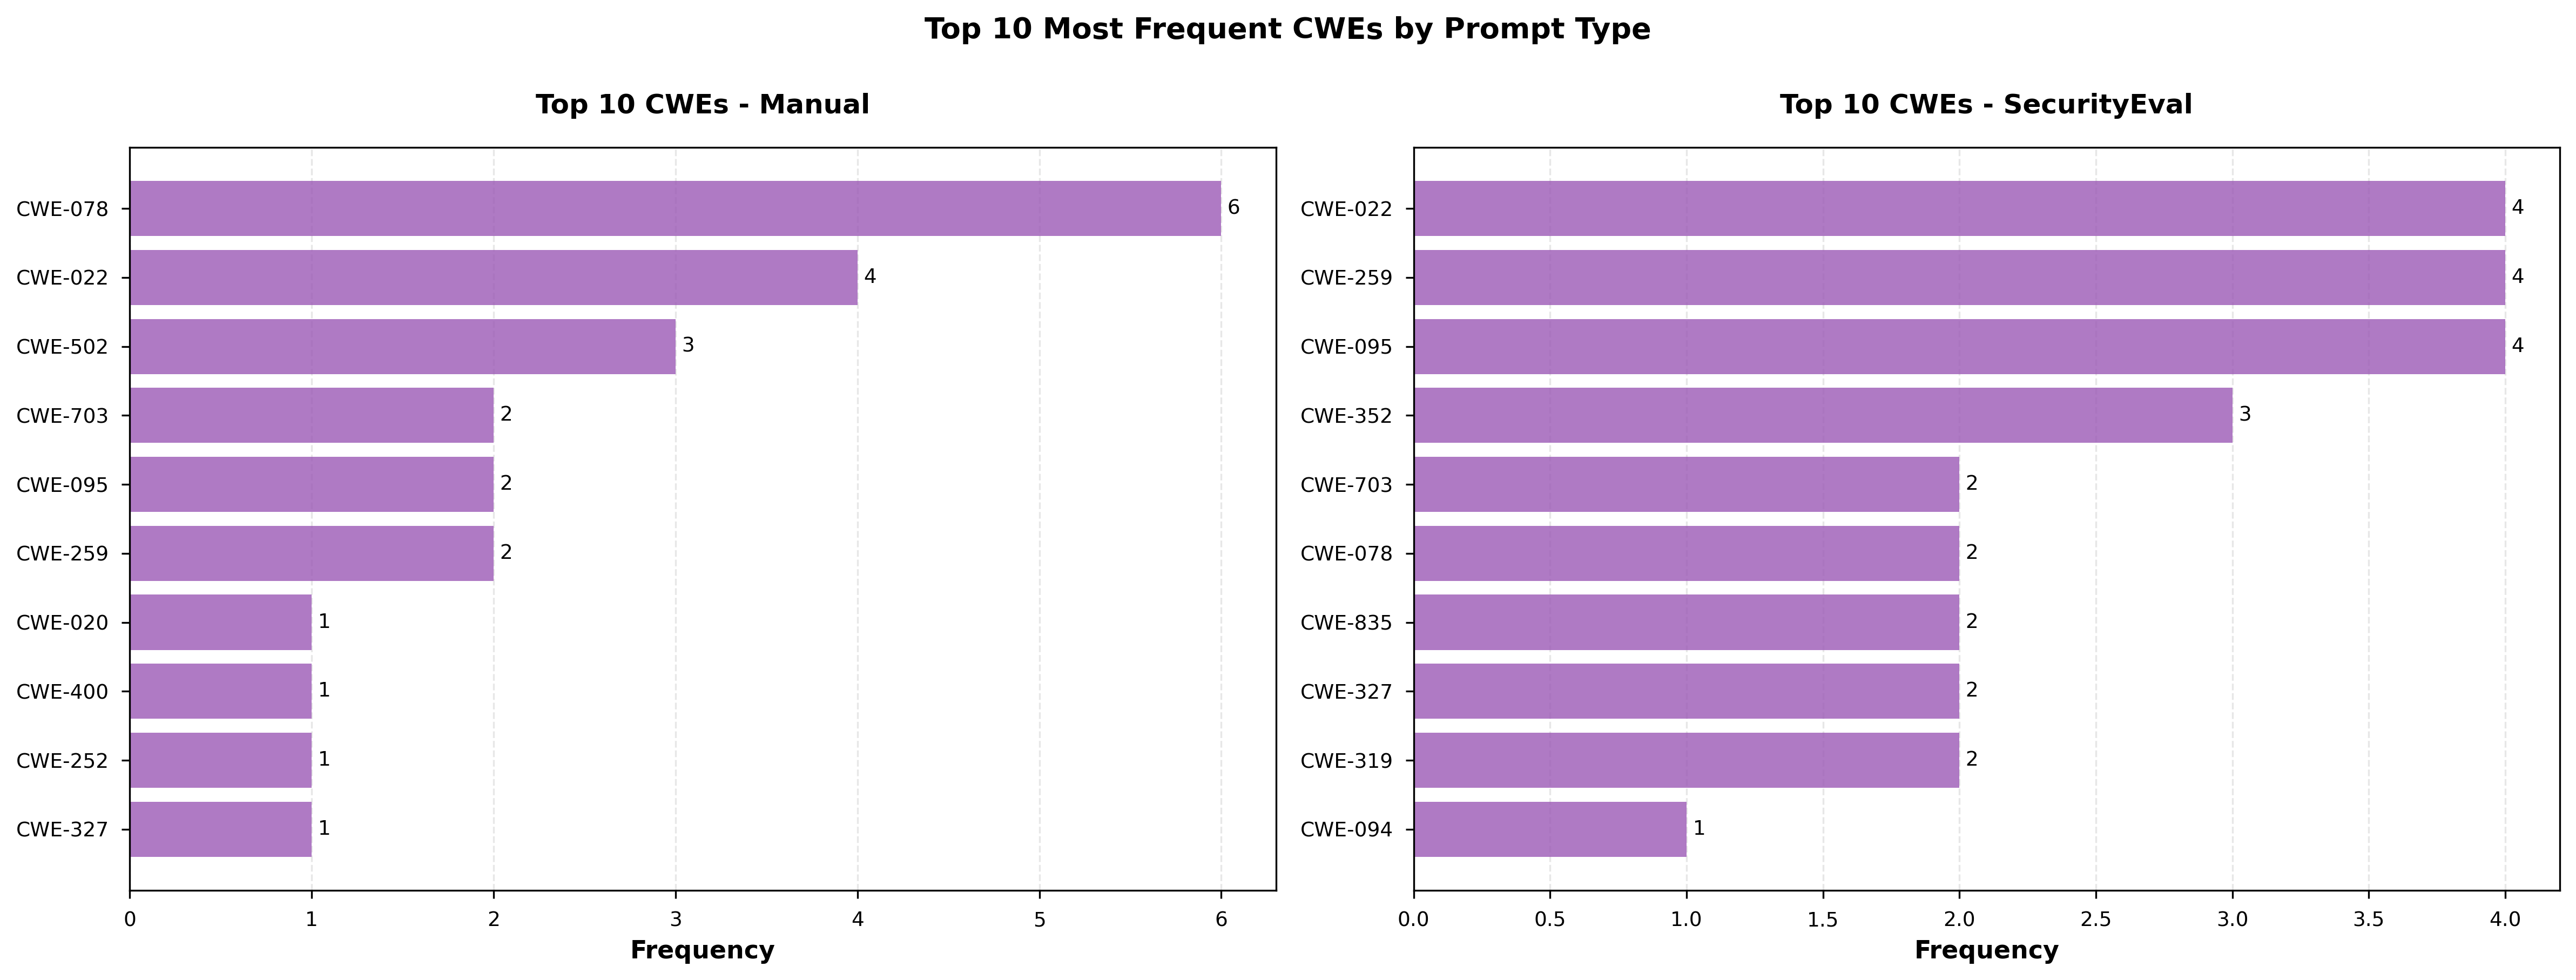

In [8]:
def extract_all_cwes(df_subset: pd.DataFrame) -> List[str]:
    """
    Extract all CWEs from initial detection columns.
    
    Args:
        df_subset: DataFrame subset for a prompt type
        
    Returns:
        List of all CWE IDs found
    """
    all_cwes = []
    
    cwe_columns = [
        'initial_detection_bandit_cwes',
        'initial_detection_semgrep_cwes',
        'initial_detection_ast_cwes'
    ]
    
    for _, row in df_subset.iterrows():
        for col in cwe_columns:
            cwes = row[col]
            # Handle string representation of lists
            if isinstance(cwes, str):
                try:
                    cwes = eval(cwes)
                except:
                    cwes = []
            if isinstance(cwes, list):
                all_cwes.extend(cwes)
    
    return all_cwes

# Create side-by-side bar charts for top 10 CWEs
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, prompt_type in enumerate(['Manual', 'SecurityEval']):
    df_subset = df[df['prompt_type'] == prompt_type]
    
    # Extract all CWEs
    all_cwes = extract_all_cwes(df_subset)
    
    # Count CWE frequencies
    if all_cwes:
        cwe_counts = pd.Series(all_cwes).value_counts().head(10)
        
        ax = axes[idx]
        
        # Create bar chart
        bars = ax.barh(range(len(cwe_counts)), cwe_counts.values, color='#9b59b6', alpha=0.8)
        
        # Add value labels
        for i, (cwe, count) in enumerate(zip(cwe_counts.index, cwe_counts.values)):
            ax.text(count, i, f' {count}', va='center', fontsize=9)
        
        ax.set_yticks(range(len(cwe_counts)))
        ax.set_yticklabels([f'CWE-{cwe}' for cwe in cwe_counts.index])
        ax.invert_yaxis()
        ax.set_xlabel('Frequency', fontweight='bold')
        ax.set_title(f'Top 10 CWEs - {prompt_type}', fontweight='bold', pad=15)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
    else:
        axes[idx].text(0.5, 0.5, 'No CWE data available', 
                       ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'Top 10 CWEs - {prompt_type}', fontweight='bold', pad=15)

fig.suptitle('Top 10 Most Frequent CWEs by Prompt Type', 
             fontweight='bold', fontsize=13, y=1.00)
plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / 'fig3_top10_cwes.png'
plt.savefig(fig_path, bbox_inches='tight', dpi=300)
print(f"✓ Figure saved: {fig_path}")

plt.show()

## 3. Prompt-Level Aggregation

In [9]:
# Group by prompt and compute aggregations
prompt_aggregation = df.groupby('prompt').agg({
    'workflow_id': 'count',  # Number of occurrences
    'vulnerabilities_found': 'sum',  # Total vulnerabilities found
    'initial_detection_bandit_count': 'sum',
    'initial_detection_semgrep_count': 'sum',
    'initial_detection_ast_count': 'sum',
    'total_vulnerabilities_fixed': 'sum',
    'total_vulnerabilities_remaining': 'sum',
    'prompt_type': 'first'  # Assume all occurrences of same prompt have same type
}).reset_index()

# Rename columns for clarity
prompt_aggregation.columns = [
    'prompt',
    'occurrences',
    'total_vulnerabilities_found',
    'total_bandit_detections',
    'total_semgrep_detections',
    'total_ast_detections',
    'total_fixed',
    'total_remaining',
    'prompt_type'
]

# Add total initial detections column
prompt_aggregation['total_initial_detections'] = (
    prompt_aggregation['total_bandit_detections'] +
    prompt_aggregation['total_semgrep_detections'] +
    prompt_aggregation['total_ast_detections']
)

# Sort by total vulnerabilities found (descending)
prompt_aggregation = prompt_aggregation.sort_values('total_vulnerabilities_found', ascending=False)

print("=" * 80)
print("PROMPT-LEVEL AGGREGATION")
print("=" * 80)
print(f"Total unique prompts: {len(prompt_aggregation)}")
print(f"\nPrompts by type:")
print(prompt_aggregation['prompt_type'].value_counts())

print(f"\nTop 10 prompts by total vulnerabilities found:")
print(prompt_aggregation[[
    'prompt_type', 'occurrences', 'total_vulnerabilities_found',
    'total_initial_detections', 'total_fixed', 'total_remaining'
]].head(10).to_string(index=False))

# Save to CSV
agg_path = OUTPUT_DIR / 'rq1_prompt_aggregation.csv'
prompt_aggregation.to_csv(agg_path, index=False)
print(f"\n✓ Prompt aggregation saved to: {agg_path}")

PROMPT-LEVEL AGGREGATION
Total unique prompts: 42

Prompts by type:
prompt_type
SecurityEval    42
Name: count, dtype: int64

Top 10 prompts by total vulnerabilities found:
 prompt_type  occurrences  total_vulnerabilities_found  total_initial_detections  total_fixed  total_remaining
SecurityEval            1                           14                         2           13                1
SecurityEval            1                            9                         1            8                1
SecurityEval            1                            8                         1            8                0
SecurityEval            1                            8                         1            8                0
SecurityEval            1                            7                         1            6                1
SecurityEval            1                            7                         1            6                1
SecurityEval            1                         

### Summary Statistics on Prompt Aggregation

In [10]:
# Summary statistics by prompt type
print("\n" + "=" * 80)
print("PROMPT AGGREGATION SUMMARY BY TYPE")
print("=" * 80)

for prompt_type in ['Manual', 'SecurityEval']:
    df_type = prompt_aggregation[prompt_aggregation['prompt_type'] == prompt_type]
    
    print(f"\n{prompt_type}:")
    print(f"  Unique prompts: {len(df_type)}")
    print(f"  Total occurrences: {df_type['occurrences'].sum()}")
    print(f"  Total vulnerabilities found: {df_type['total_vulnerabilities_found'].sum()}")
    print(f"  Avg vulnerabilities per prompt: {df_type['total_vulnerabilities_found'].mean():.2f}")
    print(f"  Total fixed: {df_type['total_fixed'].sum()}")
    print(f"  Total remaining: {df_type['total_remaining'].sum()}")
    
    if df_type['total_vulnerabilities_found'].sum() > 0:
        fix_rate = df_type['total_fixed'].sum() / df_type['total_vulnerabilities_found'].sum() * 100
        print(f"  Overall fix rate: {fix_rate:.2f}%")


PROMPT AGGREGATION SUMMARY BY TYPE

Manual:
  Unique prompts: 0
  Total occurrences: 0
  Total vulnerabilities found: 0
  Avg vulnerabilities per prompt: nan
  Total fixed: 0
  Total remaining: 0

SecurityEval:
  Unique prompts: 42
  Total occurrences: 42
  Total vulnerabilities found: 95
  Avg vulnerabilities per prompt: 2.26
  Total fixed: 91
  Total remaining: 4
  Overall fix rate: 95.79%


## Summary Report

In [11]:
print("\n" + "=" * 80)
print("RQ1 DESCRIPTIVE ANALYSIS COMPLETE")
print("=" * 80)

print("\nGenerated outputs:")
print(f"  1. Descriptive statistics: {OUTPUT_DIR / 'rq1_descriptive_stats.csv'}")
print(f"  2. Prompt aggregation: {OUTPUT_DIR / 'rq1_prompt_aggregation.csv'}")
print(f"  3. Figure 1 (Vulnerable comparison): {FIGURES_DIR / 'fig1_vulnerable_comparison.png'}")
print(f"  4. Figure 2 (Histograms): {FIGURES_DIR / 'fig2_vulnerabilities_histogram.png'}")
print(f"  5. Figure 3 (Top 10 CWEs): {FIGURES_DIR / 'fig3_top10_cwes.png'}")

print("\nKey findings:")
print(f"  - Manual prompts: {stats_manual['total_workflows']} workflows, "
      f"{stats_manual['percentage_vulnerable']:.1f}% vulnerable")
print(f"  - SecurityEval prompts: {stats_securityeval['total_workflows']} workflows, "
      f"{stats_securityeval['percentage_vulnerable']:.1f}% vulnerable")
print(f"  - Mean vulnerabilities (Manual): {stats_manual['mean_vulnerabilities']:.2f}")
print(f"  - Mean vulnerabilities (SecurityEval): {stats_securityeval['mean_vulnerabilities']:.2f}")

print("\n" + "=" * 80)


RQ1 DESCRIPTIVE ANALYSIS COMPLETE

Generated outputs:
  1. Descriptive statistics: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\rq1_descriptive_stats.csv
  2. Prompt aggregation: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\rq1_prompt_aggregation.csv
  3. Figure 1 (Vulnerable comparison): d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig1_vulnerable_comparison.png
  4. Figure 2 (Histograms): d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig2_vulnerabilities_histogram.png
  5. Figure 3 (Top 10 CWEs): d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\rq1_analysis\figures\fig3_top10_cwes.png

Key findings:
  - Manual prompts: 42 workflows, 31.0% vulnerable
  - SecurityEval prompts: 42 workflows, 50.0% vulnerable
  - Mean vulnerabilities (Manual): 2.86
  - Mean vulnerabilities (SecurityEval): 2.26

